Notebook para generar un modelo para predecir los ing_hab en la suma de los 6 hoteles de la tabla ocupaciones

In [1]:
# Python
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
import numpy as np
import joblib

d:\claseMreporeto\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar el dataset (Ocupacion)

In [2]:
ocupaciones = pd.read_excel("../data/ocupaciones_time_seriesN.xlsx").sort_values(
    "Fecha_hoy",
    ascending=True,
)

ocupaciones.head()

,Fecha_hoy,ing_hab,cto_noc,ADR,num_men,num_adu,TREVPEC,tasa_ocupacion
0,2020-11-01,1.715301e+06,868,882743.045344,396,1734,4.954178e+06,0.241918
1,2020-11-02,1.605618e+06,802,786858.344483,460,1616,4.468895e+06,0.223523
2,2020-11-03,1.516994e+06,760,712142.781526,400,1536,3.956707e+06,0.211817
3,2020-11-04,1.179054e+06,574,662056.363734,200,1114,3.705596e+06,0.159978
4,2020-11-05,1.706119e+06,816,887530.745699,256,1646,4.758461e+06,0.227425


In [ ]:
ocupaciones["ing_hab"].mean()

np.float64(4848678.336591399)

: 

# Preprocesamiento

### Renombrar el nombre de las columnas para usar el modelo prophet

In [3]:
# Example: Load data

df = ocupaciones[['Fecha_hoy','ing_hab']]
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])
#df['cap'] = 1.0  # upper bound
#df['floor'] = 0.0  # optional lower bound (default is 0)

C:\Users\angel\AppData\Local\Temp\ipykernel_17168\3971849289.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds'])


# Mostrar la serie de tiempo

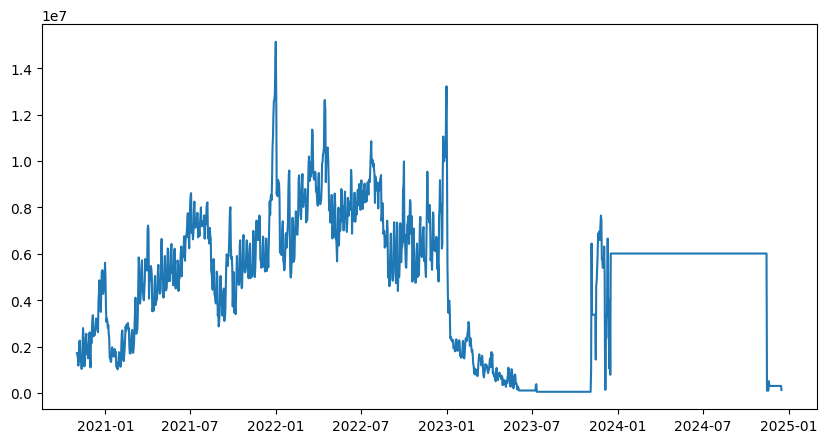

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual')

Después de 2022, parece tener un comportamiento atípico, acotar la TS hasta diciembre 2022

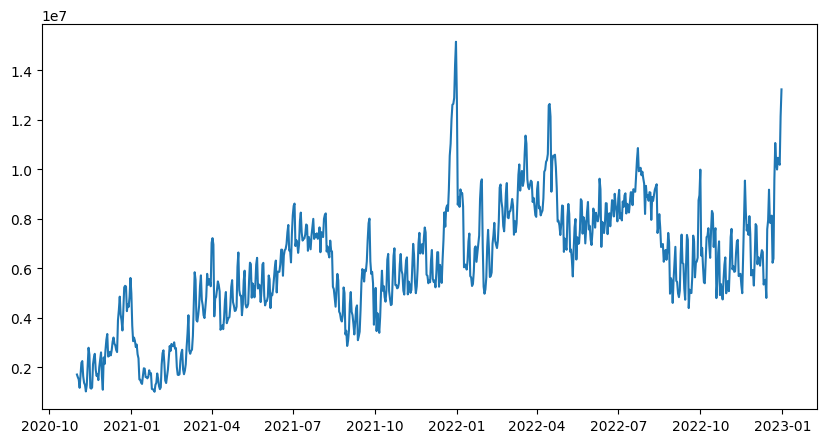

In [5]:
# Select df until 'Fecha_hoy' < '2023-01-01'
df= df[df['ds'] < '2023-01-01']
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual')


In [6]:
date_range = pd.date_range(start=ocupaciones['Fecha_hoy'].min(), end=ocupaciones['Fecha_hoy'].max(), freq='D')
missing_dates = set(date_range) - set(ocupaciones['Fecha_hoy'])

complete_time_series = ocupaciones
if missing_dates:
    print(f"Fechas faltantes en serie de tiempo: {len(missing_dates)}")
else:
    print("No hay fechas faltantes en la serie de tiempo.")

No hay fechas faltantes en la serie de tiempo.


Parece no ser una serie estacionaria, posiblemente por la influencia de la pandemia de COVID-19

# Comprobar si se trata de una serie estacionaria

## Descomponer la serie de tiempo (TS) en sus distintas componentes

<Figure size 640x480 with 0 Axes>

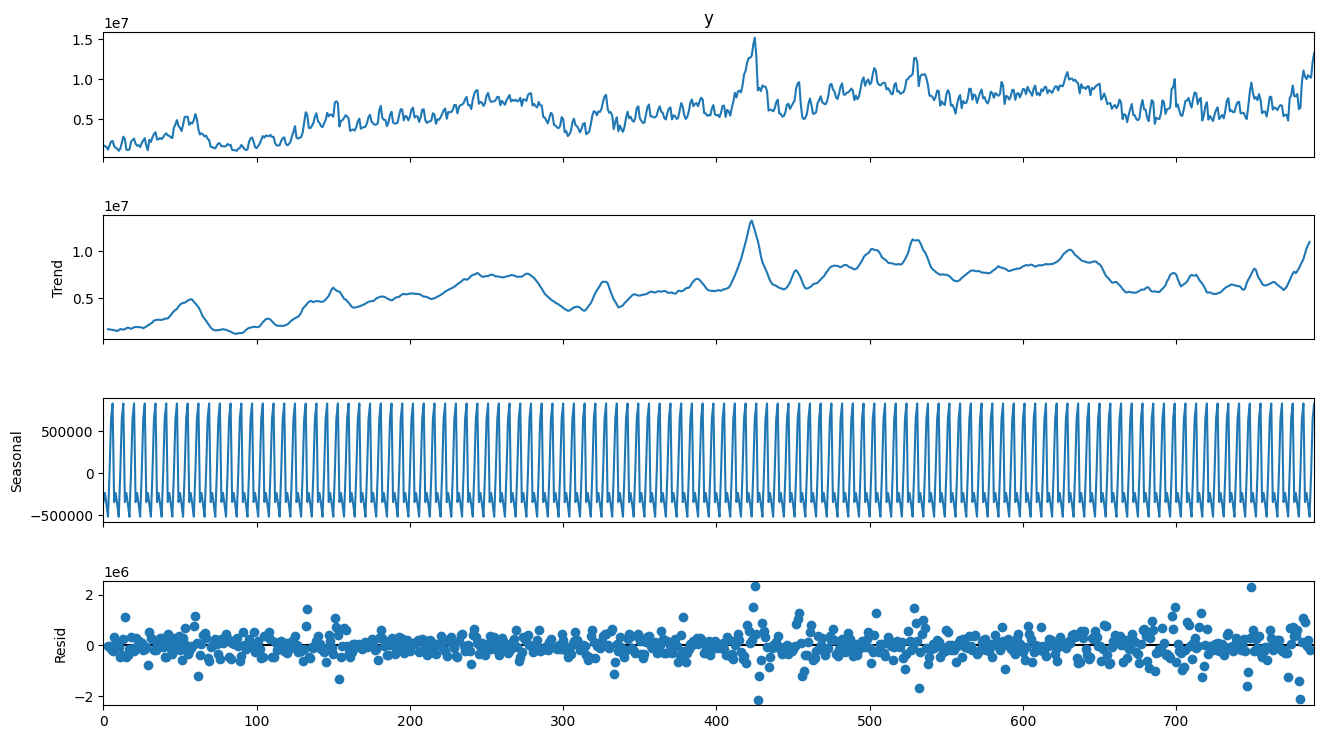

In [7]:
decomposition = seasonal_decompose(df['y'], period=7)  
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [8]:
data_trend = decomposition._trend
data_seasonal = decomposition._seasonal
data_ramdom = decomposition._resid

- La componente de tendencia parece decrecer de forma lineal, mientras que la estacional se repite de forma continua y los residuos parecen estar muy cercanos a cero

## Examen de estacionalidad: Componente ARIMA

---

Test estadistico:

1. Hipótesis nula:	Los datos son no estacionarios

2. Hipótesis alterna:	Los datos son estacionarios


Acción --> Rechaza H0 cuando el estadístico de prueba > valor crítico

In [9]:
def adfuller_w_decision(series_main_column):
    adf_test = adfuller(series_main_column)
    print('--------------------------------------------------------------------------------------')
    print('| ADF Statistic: %f' % adf_test[0])
    for key,value in adf_test[4].items():
        print(f'| Critical Value (Nivel de significancia {key}): ' + str(value))
    print('| p-value: %f' % adf_test[1])
    print('--------------------------------------------------------------------------------------')
    print('| Test a nivel de significancia 1%:')
    if adf_test[0] > adf_test[4]['5%']:
        print('| ')
        print('| No hay suficiente evidencia para rechazar H0. Los datos NO son estacionarios.')
        print('--------------------------------------------------------------------------------------')
    else:
        print('| ')
        print('| Hay evidencia para rechazar H0 y aceptar Ha. Los datos SI son estacionarios.')
        print('--------------------------------------------------------------------------------------')

adfuller_w_decision(df['y'])

--------------------------------------------------------------------------------------
| ADF Statistic: -2.405758
| Critical Value (Nivel de significancia 1%): -3.438882201132452
| Critical Value (Nivel de significancia 5%): -2.865305765357574
| Critical Value (Nivel de significancia 10%): -2.568775270215655
| p-value: 0.140118
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| No hay suficiente evidencia para rechazar H0. Los datos NO son estacionarios.
--------------------------------------------------------------------------------------


# Aplicar SARIMA

Encontrar parametros

## D y d

---

### d

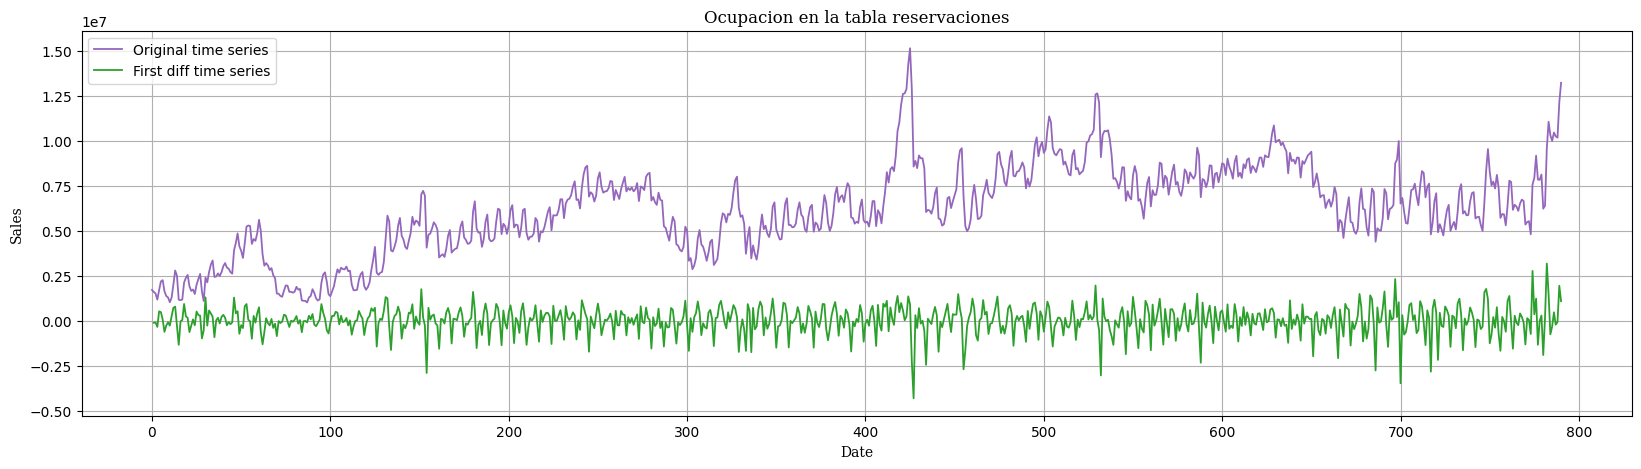

--------------------------------------------------------------------------------------
| ADF Statistic: -6.983730
| Critical Value (Nivel de significancia 1%): -3.4388933482333464
| Critical Value (Nivel de significancia 5%): -2.8653106782623574
| Critical Value (Nivel de significancia 10%): -2.5687778874376086
| p-value: 0.000000
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| Hay evidencia para rechazar H0 y aceptar Ha. Los datos SI son estacionarios.
--------------------------------------------------------------------------------------


In [10]:
first_diff = (df['y'] - df['y'].shift(1))[1:]

#Plot config
font_name = "Serif"

# Plot the time series
plt.figure(figsize=(20,5))
plt.plot(df['y'],linewidth=1.3, c='tab:purple', label = 'Original time series')
plt.plot(first_diff,linewidth=1.3, c='tab:green', label = 'First diff time series')
plt.title('Ocupacion en la tabla reservaciones', fontname=font_name)
plt.xlabel('Date', fontname=font_name)
plt.ylabel('Sales', fontname=font_name)
plt.legend()
plt.grid()
plt.show()

#Applying ADF test on the first order differentiation of the time series
adfuller_w_decision(first_diff)

### Encontrar D, con la componente de estacionalidad

In [11]:
print(adfuller_w_decision(data_seasonal))

print('--------------------------------------------------------------------------------------')

print('Los datos de la componente estacional no son estacionarios, por lo que se procede a aplicar la diferenciacion de primer orden.')

print('--------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------
| ADF Statistic: 0.000000
| Critical Value (Nivel de significancia 1%): -3.438804978547988
| Critical Value (Nivel de significancia 5%): -2.8652717302548396
| Critical Value (Nivel de significancia 10%): -2.5687571389759802
| p-value: 0.958532
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| No hay suficiente evidencia para rechazar H0. Los datos NO son estacionarios.
--------------------------------------------------------------------------------------
None
--------------------------------------------------------------------------------------
Los datos de la componente estacional no son estacionarios, por lo que se procede a aplicar la diferenciacion de primer orden.
--------------------------------------------------------------------------------------


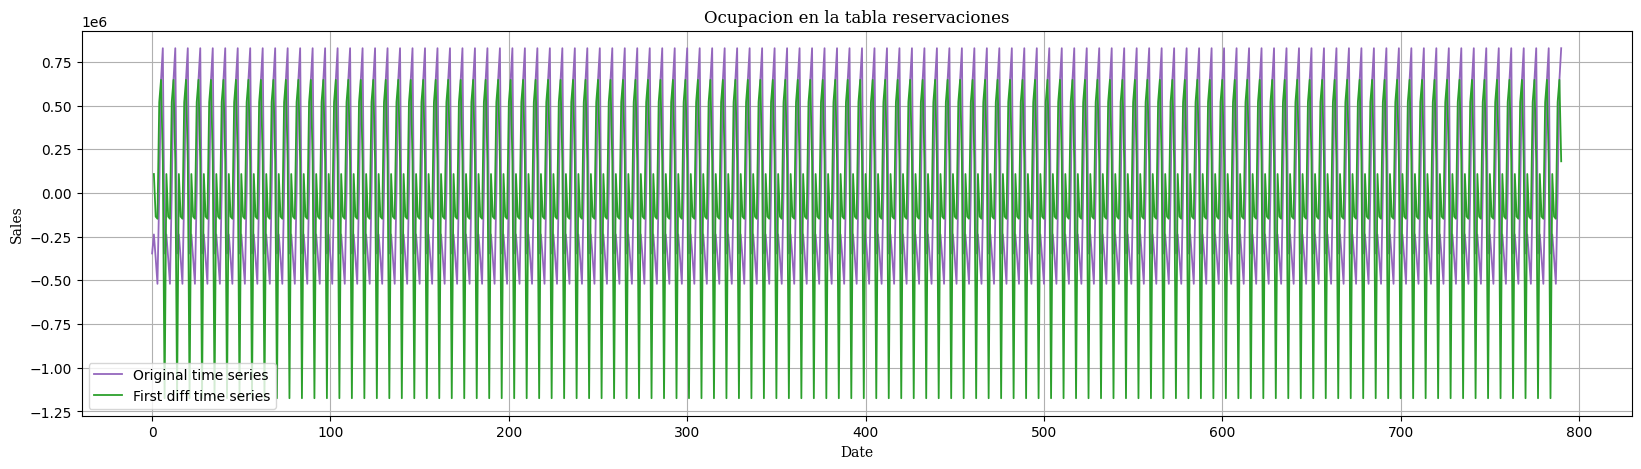

--------------------------------------------------------------------------------------
| ADF Statistic: -12226650206008274.000000
| Critical Value (Nivel de significancia 1%): -3.438837902109151
| Critical Value (Nivel de significancia 5%): -2.8652862410999114
| Critical Value (Nivel de significancia 10%): -2.568764869203001
| p-value: 0.000000
--------------------------------------------------------------------------------------
| Test a nivel de significancia 1%:
| 
| Hay evidencia para rechazar H0 y aceptar Ha. Los datos SI son estacionarios.
--------------------------------------------------------------------------------------


In [12]:
first_diff_s = (data_seasonal - data_seasonal.shift(1))[1:]

#Plot config
font_name = "Serif"

# Plot the time series
plt.figure(figsize=(20,5))
plt.plot(data_seasonal,linewidth=1.3, c='tab:purple', label = 'Original time series')
plt.plot(first_diff_s,linewidth=1.3, c='tab:green', label = 'First diff time series')
plt.title('Ocupacion en la tabla reservaciones', fontname=font_name)
plt.xlabel('Date', fontname=font_name)
plt.ylabel('Sales', fontname=font_name)
plt.legend()
plt.grid()
plt.show()

#Applying ADF test on the first order differentiation of the time series
adfuller_w_decision(first_diff_s)


### Resultados:

- D=1

- d=1

## P, Q y p,q

p = autocorrelación parcial

q = autocorrelación 

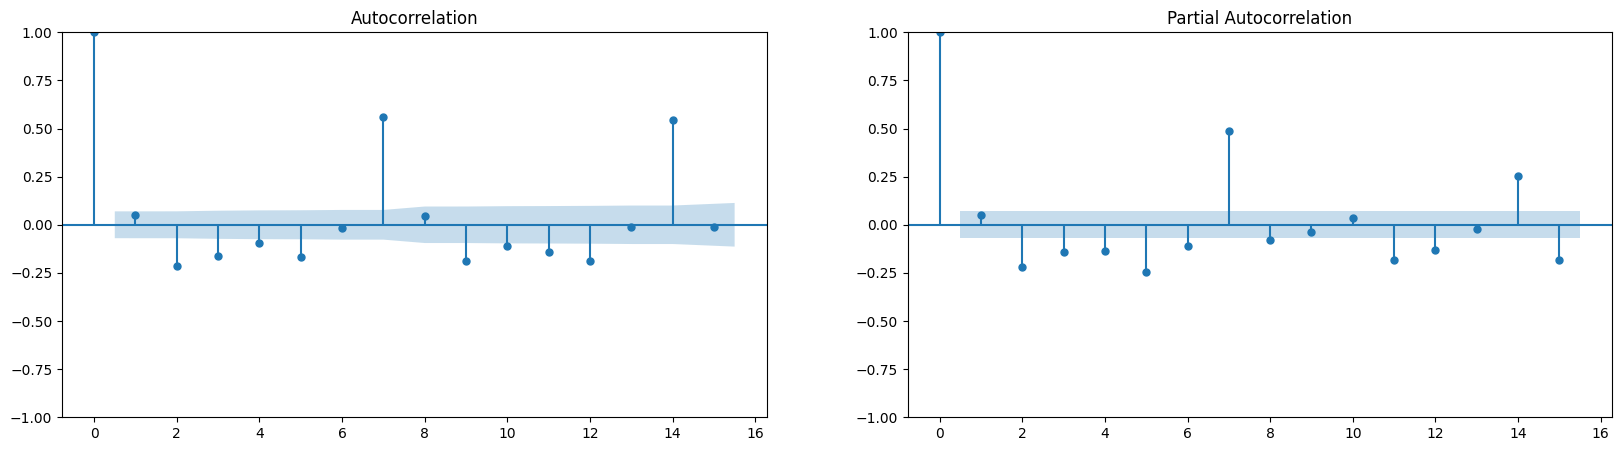

In [13]:
def autocorrelation_plots(series_main_column, lags):
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    plot_acf(series_main_column, lags=lags, ax=ax[0])
    plot_pacf(series_main_column, lags=lags, ax=ax[1])
    plt.show()

autocorrelation_plots(first_diff, 15)

Para la serie original desplazada usar `q=0 p=0`

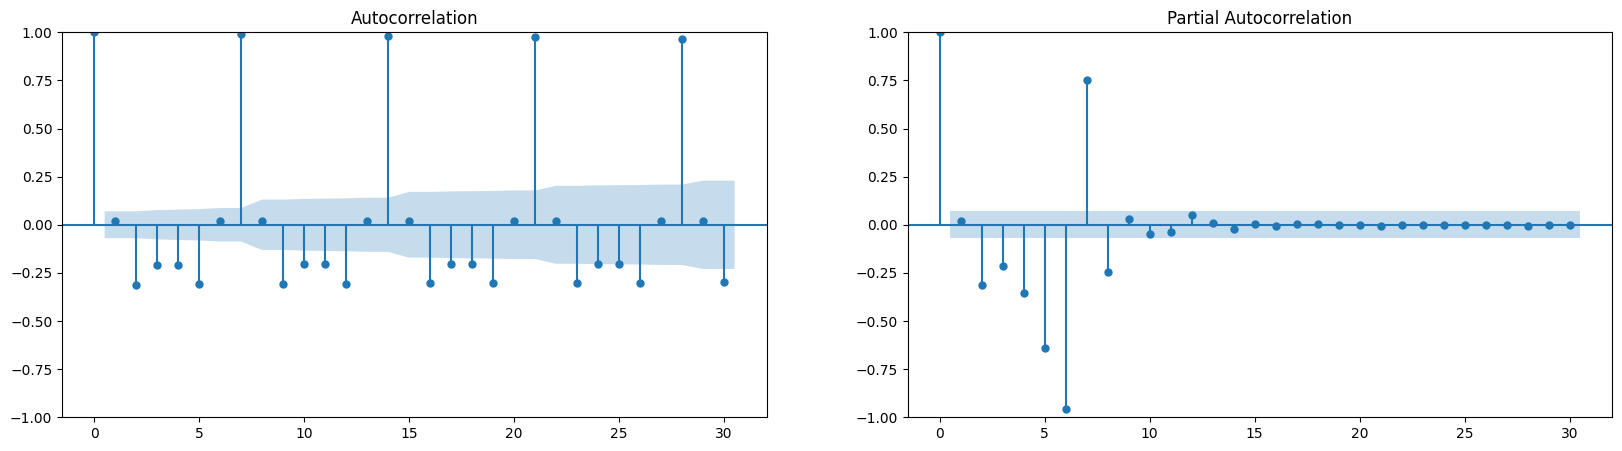

In [14]:
autocorrelation_plots(first_diff_s, 30)

Para la serie estacional usar `Q=5 P=8`

## Construccion del modelo

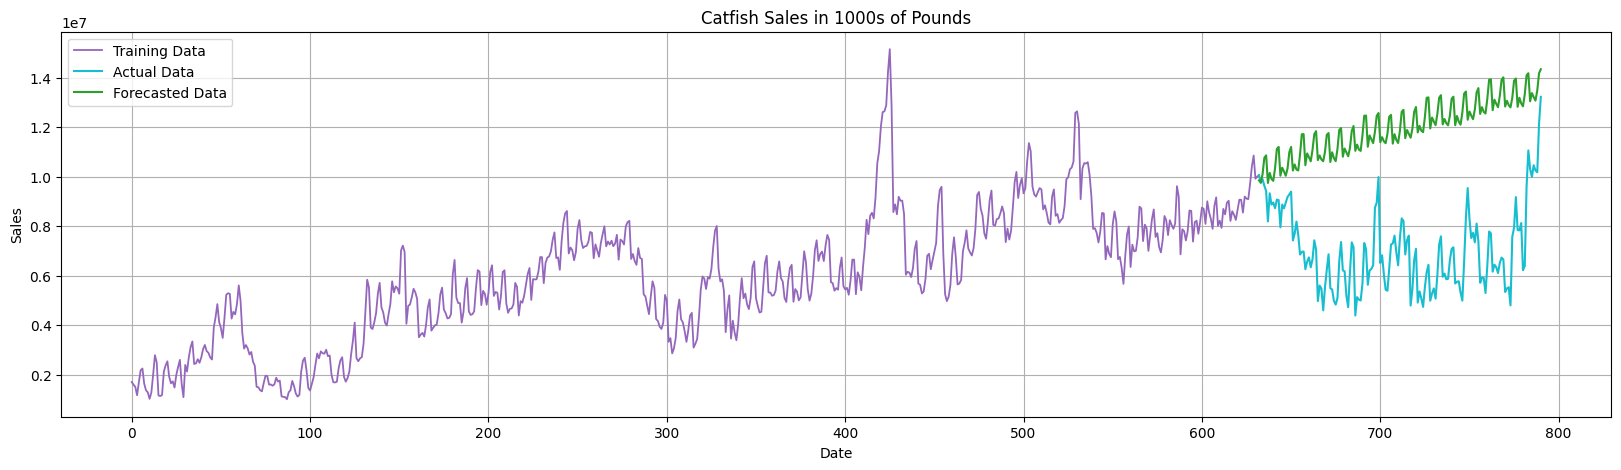

In [15]:
warnings.filterwarnings('ignore')
# Split the data into train and test
#train_size = int(len(data) * 0.8)
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# Fit the ARIMA model on the training dataset
model_train = SARIMAX(train['y'], order=(0, 1, 0), seasonal_order = (8, 1, 5, 7))
model_train_fit = model_train.fit(disp=0)

# Forecast on the test dataset
test_forecast = model_train_fit.forecast(len(test))
test_forecast_series = pd.Series(test_forecast, index=test.index)

#Plot config
font_name = "Serif"

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(20,5))
plt.plot(df[0:train_size+1]['y'],linewidth=1.3, c='tab:purple', label='Training Data')
plt.plot(test['y'], label='Actual Data', color='tab:cyan')
plt.plot(test_forecast_series, label='Forecasted Data', color='tab:green')
plt.title('Catfish Sales in 1000s of Pounds')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [23]:

residuals = test['y'] - test_forecast_series
rmse = mean_squared_error(test['y'], test_forecast_series)**0.5
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['y'])),len(residuals))*100)
print('Mean Absolute Error:', mean_absolute_error(test['y'], test_forecast_series))

Root Mean Squared Error (RMSE): 5252546.612393171
Mean Absolute Percent Error: 77.98732418925914
Mean Absolute Error: 4912549.460478687


El modelo SARIMA refleja un rendimiento positivo para la predicción de ocupación hotelera en el set de entrenamiento.

# Modelo `PROPHET`

---

Para comparar el rendimeinto de SARIMA se utilizará el modelo PROPHET desarrollado por un equipo de ingenieros de META

*Permite agregar días especiales*

In [24]:
mexican_holidays = pd.DataFrame({
    'holiday': [
        'New Year\'s Day', 'Constitution Day', 'Benito Juárez Day',
        'Labor Day', 'Independence Day', 'Revolution Day',
        'Christmas Day1', 'ChristmasDay2', 'ChristmasDay3', 'Christmas Day4', 'ChristmasDay5', 'ChristmasDay6',
        'Christmas Day7', 'ChristmasDay8', 'ChristmasDay9', 'Christmas Day10', 'ChristmasDay11',
          'Day of the Dead', 'Holy Thursday', 'Good Friday'
    ],
    'ds': pd.to_datetime([
        '2024-01-01',  # Año Nuevo
        '2024-02-05',  # Día de la Constitución (first Monday of Feb)
        '2024-03-18',  # Natalicio de Benito Juárez (observed)
        '2024-05-01',  # Día del Trabajo
        '2024-09-16',  # Día de la Independencia
        '2024-11-18',  # Día de la Revolución (observed)
        '2024-12-21',  # Navidad
        '2024-12-22',  # Navidad
        '2024-12-23',  # Navidad
        '2024-12-24',  # Navidad
        '2024-12-25',  # Navidad
        '2024-12-26',  # Navidad
        '2024-12-27',  # Navidad
        '2024-12-28',  # Navidad
        '2024-12-29',  # Navidad
        '2024-12-30',  # Navidad
        '2024-12-31',  # Navidad
        '2024-11-02',  # Día de Muertos
        '2024-03-28',  # Jueves Santo
        '2024-03-29',  # Viernes Santo
    ]),
    'lower_window': -2,
    'upper_window': 2
})

## Generar el modelo

## Entrenamiento

In [25]:
model = Prophet(growth='linear',holidays=mexican_holidays)
model.fit(train)

22:22:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing


## Predicciones sobre el set de entrenamiento y métricas de rendimiento

In [26]:
future = test[['ds']]  # Use the actual dates from your test set
#future['cap'] = 1.0
#future['floor'] = 0.0
forecast = model.predict(future)

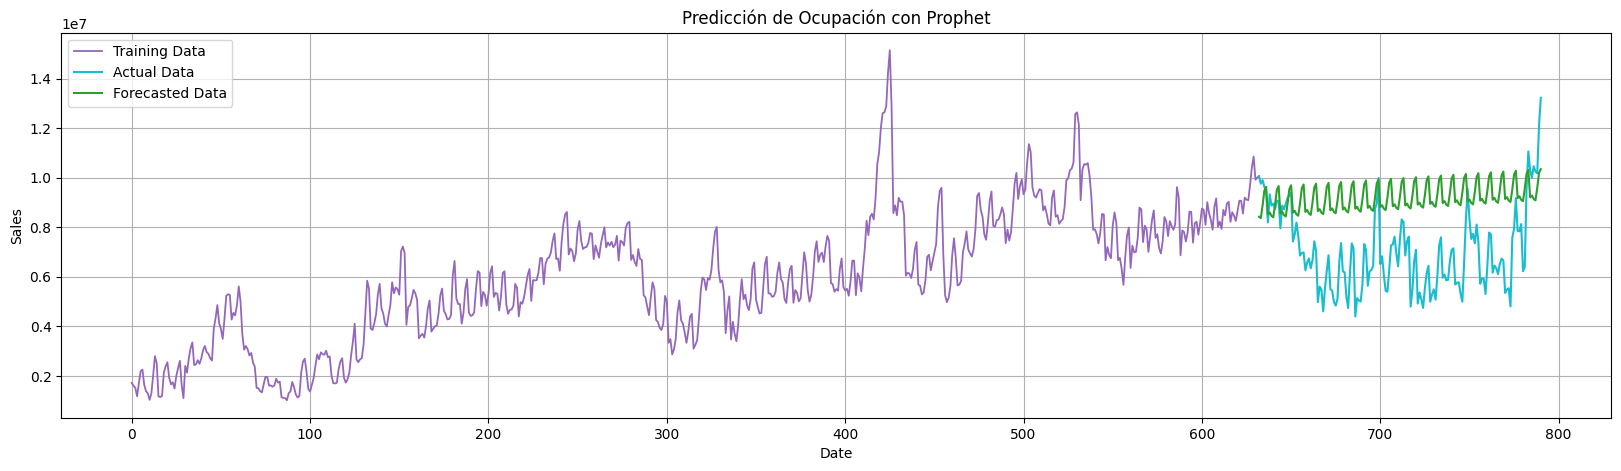

In [27]:
#Plot config
font_name = "Serif"

graph_forecast =pd.DataFrame({
    
    'yhat': forecast['yhat'],
})
graph_forecast.index = test.index

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(20,5))
plt.plot(df[0:train_size+1]['y'],linewidth=1.3, c='tab:purple', label='Training Data')
plt.plot(test['y'], label='Actual Data', color='tab:cyan')
plt.plot(graph_forecast, label='Forecasted Data', color='tab:green')
plt.title('Predicción de Ocupación con Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

In [29]:
# Compare predicted 'yhat' to actual 'y'
y_true = test['y'].values
y_pred = forecast['yhat'].values

residuals = y_true - y_pred
rmse = mean_squared_error(test['y'], y_pred)**0.5
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['y'])),len(residuals))*100)
print('Mean Absolute Error:', mean_absolute_error(test['y'], y_pred))


Root Mean Squared Error (RMSE): 2653420.70981282
Mean Absolute Percent Error: 38.815171737732236
Mean Absolute Error: 2379707.051307671


# Conclusión

El modelo de PROPHET supera al de SARIMA en el RMSE, por lo que se usará como predicción. Parece ser que su capacidad de tener en cuenta el ruido y días festivos lo hace mejor para este problema

# Guardar el modelo

In [22]:
# Save the model
joblib.dump(model, '../models/prophet_modelInghab.pkl')

['../models/prophet_modelInghab.pkl']